# CNC Industrial Dataset
> Reproduces the results from the CNC industrial dataset.

Here, we will reproduce the results, figures, and tables from the tool wear experiments using the industrial CNC dataset. The dataset is proprietary and cannot be shared at this point. However, the features, produced from the original CNC signals, are publicly [available on Google Drive](https://drive.google.com/file/d/1-OtGeA9DDRu1GKU8CCkLSEOl0yKGaI25/view?usp=share_link).

The first step to reproduce the results is to get the proper environment setup.

## Table of Contents
* [1. Setup Notebook](#setup-notebook) - clone the repo and import require packages
* [2. Explore Data](#explore-data) - brief exploration of the data
* [3. Prep Data](#prep-data) - prepare the data by segmenting the signals into windows
* [4. Feature Engineering](#feature-engineering) - extract features from the segmented signals
* [5. Model Training](#model-training) - train the models in a random search
* [6. Filter Results](#filter-results) - filter the results to find the best models
* [7. Visualize Results](#visualize-results) - inspect the results of the random search


# 1. Setup Notebook <a name="setup-notebook"></a>
**For Google Colab:**
To run the notebook on google colab you must clone the repo an download the data using PyPHM. This can be done by running the following cell.

In [ ]:
# ONLY RUN IF YOU'RE USING GOOGLE COLAB
!git clone https://github.com/tvhahn/tspipe

# move into project folder
%cd tspipe

!pip install tsfresh pyphm
!pip install -e .

from IPython.display import clear_output
clear_output()

**Import Packages:**
Don't skip this step! Needed for Google Colab and if run locally.

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import scipy.io as sio # for reading matlab files
import zipfile
import gdown
import os
import glob

import warnings
warnings.filterwarnings("ignore") # supress all the matplotlib deprecation warnings
from IPython.display import clear_output, display, Image # incase you want to clear the output of a cell
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# set the project (root folder) and the data folder locations
path_colab = Path.cwd().parent.parent / 'content'

if path_colab.exists():
    proj_dir = Path.cwd() # get projet folder of repository - use if on colab
else:
    proj_dir = Path.cwd().parent # on local machine in ./notebooks folder

print(proj_dir) 

/home/tim/Documents/feat-store


# 2. Explore Data <a name="explore-data"></a>
Below is a sample of a raw cut signal from the roughing tool. The shaded areas (labelled sub-cuts) are when the tool is, approximately, cutting into the metal. In the preprocessing step we extract these sub-cuts and build features ontop of them.

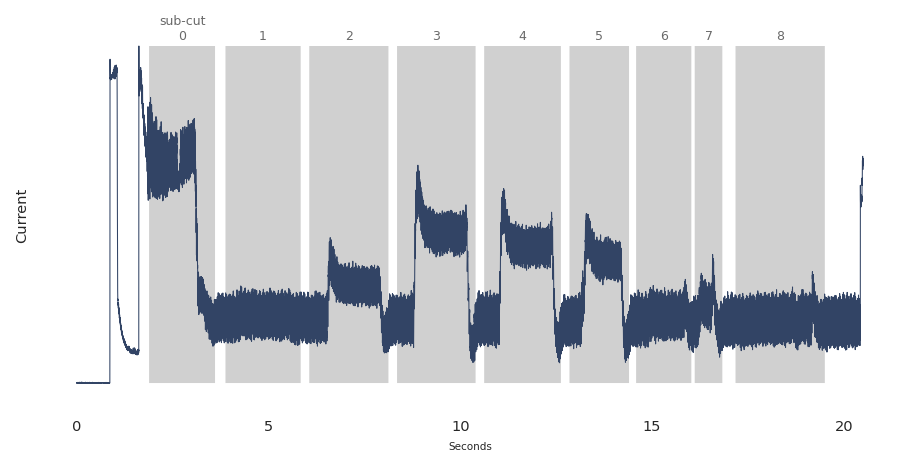

In [8]:
from src.visualization.visualize import plot_raw_cnc_signal

raw_data_dir = proj_dir / 'data' / 'raw'

df_raw = pd.read_csv(raw_data_dir / "cnc" / "tool54_example.csv")

plot_raw_cnc_signal(
    df_raw,
    save_plot=False,
    dpi=150,
)

# 3. Feature Engineering <a name="feature-engineering"></a>
Since the data is proprietary, we cannot give you all the raw data. However, we can show the features that were extracted from the individual sub-cuts. If you want to see how the features were created with tsfresh, check out the [example from the milling dataset](https://github.com/tvhahn/tspipe/blob/master/notebooks/milling-reproduction.ipynb).

Below is how you can download the feature dataset and then load it into a pandas dataframe.

In [11]:
path_processed_dir = proj_dir / 'data' / 'processed' / 'cnc' / 'cnc_features_comp_extra'
path_processed_dir.mkdir(parents=True, exist_ok=True)

In [10]:
# download the file from google drive if it hasn't been yet
zip_file_name = 'cnc_features_54_comp_extra.zip'

gdown.download(
    id='1-OtGeA9DDRu1GKU8CCkLSEOl0yKGaI25', 
    output=str(path_processed_dir / zip_file_name), 
    quiet=False
    )

# extract the zip file
print("Extracting...")
with zipfile.ZipFile(path_processed_dir / zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(path_processed_dir)

Downloading...
From: https://drive.google.com/uc?id=1-OtGeA9DDRu1GKU8CCkLSEOl0yKGaI25
To: /home/tim/Documents/feat-store/data/processed/milling/cnc_features_comp_extra/cnc_features_54_comp_extra.zip
100%|██████████| 280M/280M [00:04<00:00, 66.1MB/s] 


Extracting...


Let's look at these features:

In [12]:
# load the milling.csv.gz file with pandas
df_feat = pd.read_csv(path_processed_dir / "cnc_features_54_comp_extra.csv")
df_feat.head()

,id,current__mean_abs_change,current__abs_energy,current__mean_change,current__mean_second_derivative_central,current__median,current__mean,current__standard_deviation,current__variation_coefficient,current__variance,...,current__permutation_entropy__dimension_5__tau_1,current__permutation_entropy__dimension_6__tau_1,current__permutation_entropy__dimension_7__tau_1,current__query_similarity_count__query_None__threshold_0.0,"current__matrix_profile__feature_""min""__threshold_0.98","current__matrix_profile__feature_""max""__threshold_0.98","current__matrix_profile__feature_""mean""__threshold_0.98","current__matrix_profile__feature_""median""__threshold_0.98","current__matrix_profile__feature_""25""__threshold_0.98","current__matrix_profile__feature_""75""__threshold_0.98"
0,1540298934_54_4,43.513601,6.492213e+09,-0.038165,0.004265,1756.0,1553.010146,472.214161,0.304064,222986.213777,...,4.460390,5.843171,6.887479,NaN,1.299023,4.504875,2.893055,3.040390,2.601408,3.315690
1,1540300010_54_7,40.189124,1.788629e+09,-0.057402,-0.000907,902.0,990.251812,315.422336,0.318527,99491.249997,...,4.117279,5.229522,6.076289,NaN,1.674318,4.704647,2.995968,2.967543,2.564654,3.362198
2,1540301622_54_3,40.149332,4.487819e+09,0.034399,0.003846,1442.0,1302.019822,346.706044,0.266283,120205.080918,...,4.316023,5.603198,6.586547,NaN,1.155896,3.764852,2.058777,2.100826,1.867607,2.262170
3,1540304666_54_1,19.503940,5.812736e+09,-0.062331,-0.001882,370.0,575.791275,593.290876,1.030392,351994.063089,...,4.529267,6.022065,7.393625,NaN,3.659720,21.998922,6.972191,6.012815,5.700266,6.908160
4,1540305024_54_7,39.861631,1.848553e+09,0.010272,-0.041415,916.5,1003.512681,330.512186,0.329355,109238.305395,...,4.105759,5.223907,6.080077,NaN,1.450276,4.510552,2.466071,2.483034,2.073773,2.780033


The above features don't have any labels, so we need to add them. The labels come from the `high_level_labels_MASTER_update2022-08-18_with_case.csv` file. Let's look at it.

In [14]:
df_labels = pd.read_csv(proj_dir / 'data' / 'processed' / 'cnc' / 'high_level_labels_MASTER_update2022-08-18_with_case.csv')
df_labels.head()

,unix_date,date,case_tool_54,failed,failed_tools
0,1540298755,2018-10-23 08:45:00,1,NaN,NaN
1,1540298934,2018-10-23 08:48:00,1,NaN,NaN
2,1540299114,2018-10-23 08:51:00,1,NaN,NaN
3,1540299293,2018-10-23 08:54:00,1,NaN,NaN
4,1540299472,2018-10-23 08:57:00,1,NaN,NaN


In [11]:
# get the percentage of each tool_class
df_p = df_feat.groupby("tool_class").size() / df_feat.shape[0] * 100
df_p = df_p.reset_index()
df_p.columns = ["tool_class", "percentage"]

# get the count of each tool_class
df_c = df_feat.groupby("tool_class").size().to_frame().reset_index()
df_c.columns = ["tool_class", "count"]

# merge the two dataframes
df_pc = df_p.merge(df_c, on="tool_class")[["tool_class", "count", "percentage"]]
df_pc["percentage"] = df_pc["percentage"].round(2)
df_pc

,tool_class,count,percentage
0,0,3311,36.63
1,1,5065,56.03
2,2,664,7.35


# 5. Model Training <a name="model-training"></a>
A random search is used to find the best model and hyperparameters. The random search is implemented in the [train.py](https://github.com/tvhahn/tspipe/blob/master/src/models/train.py) script. The parameters to search over are initialized in the [random_search_setup.py](https://github.com/tvhahn/tspipe/blob/master/src/models/random_search_setup.py) -- when you clone the repo to your local computer you can modify it there.

In [12]:
DATASET = 'milling' # either 'milling' or 'cnc'
SAVE_DIR_NAME = 'interim_results_milling' # name of folder to results in
PROCESSED_DIR_NAME = 'milling_features_comp_stride64_len1024' # name of folder where features are saved
RAND_SEARCH_ITER = 2 # number of iterations for random search
FEAT_FILE_NAME = 'milling_features_comp_stride64_len1024.csv' # name of the original feature file
SAMPLE_SEED = 20 # OPTIONAL seed to fix the search space

In [25]:
# remove the sample_seed if you want a different sample
!python {proj_dir}/src/models/train.py \
    -p {proj_dir} \
    --dataset {DATASET} \
    --save_dir_name {SAVE_DIR_NAME} \
    --processed_dir_name {PROCESSED_DIR_NAME} \
    --rand_search_iter {RAND_SEARCH_ITER} \
    --feat_file_name {FEAT_FILE_NAME} \
    --sample_seed {SAMPLE_SEED}

Assume on local compute
k_folds: 7
classifier: knn, oversamp_method: svm_smote, oversamp_ratio: 0.95 undersamp_method: random_under_bootstrap undersamp_ratio: 0.4

 {'KNeighborsClassifier_metric': 'manhattan', 'KNeighborsClassifier_n_neighbors': 11, 'KNeighborsClassifier_weights': 'uniform'}
feat_select_method:  random
k_folds in kfold_cv:  7
0
####### Exception #######
The specified ratio required to generate new sample in the majority class while trying to remove samples. Please increase the ratio.
classifier: rf, oversamp_method: smote, oversamp_ratio: 1.0 undersamp_method: random_under_bootstrap undersamp_ratio: 0.6

 {'RandomForestClassifier_bootstrap': True, 'RandomForestClassifier_class_weight': None, 'RandomForestClassifier_criterion': 'gini', 'RandomForestClassifier_max_depth': 443, 'RandomForestClassifier_min_samples_leaf': 35, 'RandomForestClassifier_min_samples_split': 91, 'RandomForestClassifier_n_estimators': 305}
feat_select_method:  random
k_folds in kfold_cv:  7
0
####

The random search creates a csv file with the results of the search. In our case, the results are stored in the `interim_results_milling` folder under the name `results_{SAMPLE_SEED}.csv`.

Let's look at the results file.

In [13]:
path_interim_results_dir = proj_dir / 'models' / SAVE_DIR_NAME

# use path to find all the files in the path_interim_results_dir
# and get the latest one
list_of_files = glob.glob(str(path_interim_results_dir / '*.csv'))
latest_file = max(list_of_files, key=os.path.getctime)

print("Most recent results file: ", latest_file)

Most recent results file:  /home/tim/Documents/feat-store/models/interim_results_milling/results_20.csv


In [14]:
df_results = pd.read_csv(Path(latest_file))
df_results.head()

,undersamp_ratio,undersamp_method,scaler_method,oversamp_ratio,oversamp_method,max_feats,feat_select_method,feat_col_list,early_stopping_rounds,dataprep_method,...,n_thresholds_max,test_strat_group_worst_prauc,tn_fp_fn_tp_worst_prauc,RandomForestClassifier_bootstrap,RandomForestClassifier_class_weight,RandomForestClassifier_criterion,RandomForestClassifier_max_depth,RandomForestClassifier_min_samples_leaf,RandomForestClassifier_min_samples_split,RandomForestClassifier_n_estimators
0,NaN,NaN,minmax,0.3,smote_tomek,10,random,"['ae_spindle__fft_coefficient__attr_""abs""__coe...",NaN,milling_standard,...,3202,"[1, 9, 5, 10]","(1928, 217, 9, 141)",True,NaN,entropy,224,29,92,395
1,NaN,NaN,minmax,0.3,smote_tomek,10,random,"['ae_spindle__fft_coefficient__attr_""abs""__coe...",NaN,milling_standard,...,3202,"[1, 9, 5, 10]","(1928, 217, 9, 141)",True,NaN,entropy,224,29,92,395


# 6. Filter Results <a name="filter-results"></a>
The above results are illustrative of what the random search will do. However, if you train thousands of models, you will want to filter the results to find the best models. Many of the models will also be junk.

There may also be multiple "results" csv files in the interim results folder. We can combine these into one using the [compile.py](https://github.com/tvhahn/tspipe/blob/master/src/models/compile.py) script. For now, we will download the compiled results file from Google Drive and filter it.

In [15]:
path_final_results_dir = proj_dir / 'models' / 'final_results_milling'
path_final_results_dir.mkdir(parents=True, exist_ok=True)

In [16]:
zip_file_name = 'compiled_results_milling_2022_08_25_final.zip'

# download the file from google drive if it hasn't been yet
gdown.download(
    id='1zpNLw2wsX4RCMGmY7Wl0aEidDCiAJJ-P', 
    output=str(path_final_results_dir / zip_file_name), 
    quiet=False
    )

# extract the zip file
print("Extracting...")
with zipfile.ZipFile(path_final_results_dir / zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(path_final_results_dir)

Downloading...
From: https://drive.google.com/uc?id=1zpNLw2wsX4RCMGmY7Wl0aEidDCiAJJ-P
To: /home/tim/Documents/feat-store/models/final_results_milling/compiled_results_milling_2022_08_25_final.zip
100%|██████████| 25.8M/25.8M [00:00<00:00, 53.9MB/s]


Extracting...


Let's open up the `compiled_results.csv` file, which we just extracted, and take a look at it.

In [19]:
df_results = pd.read_csv(path_final_results_dir / 'compiled_results.csv')

print("Number of results: ", df_results.shape[0])
df_results.head()

Number of results:  73274


,classifier,sampler_seed,date_time,dataset,dataprep_method,feat_file_name,id,meta_label_cols,feat_select_method,max_feats,...,KNeighborsClassifier_weights,XGB_alpha,XGB_eta,XGB_eval_metric,XGB_lambda,XGB_max_depth,XGB_objective,XGB_scale_pos_weight,XGB_seed,SVC_degree
0,ridge,30402896,2022-09-14-1244-20,milling,milling_standard,milling_features_comp_stride64_len1024.csv,30402896_ridge_2022-09-14-1244-20_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,lr,8625985,2022-09-14-1252-42,milling,milling_standard,milling_features_comp_stride64_len1024.csv,8625985_lr_2022-09-14-1252-42_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sgd,30813941,2022-09-14-1254-45,milling,milling_standard,milling_features_comp_stride64_len1024.csv,30813941_sgd_2022-09-14-1254-45_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sgd,7195055,2022-09-14-1301-57,milling,milling_standard,milling_features_comp_stride64_len1024.csv,7195055_sgd_2022-09-14-1301-57_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,lr,19164765,2022-09-14-1304-12,milling,milling_standard,milling_features_comp_stride64_len1024.csv,19164765_lr_2022-09-14-1304-12_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Many of the above models are poorly performing. We will use the [filter.py](https://github.com/tvhahn/tspipe/blob/master/src/models/filter.py) script to filter the results.

In [22]:
DATASET = 'milling' # either 'milling' or 'cnc'
PROCESSED_DIR_NAME = 'milling_features_comp_stride64_len1024' # name of folder where features are saved
FEAT_FILE_NAME = 'milling_features_comp_stride64_len1024.csv' # name of the original feature file
FINAL_DIR_NAME = 'final_results_milling' # name of folder where final results are saved
KEEP_TOP_N = 1 # keeq top n results of each model type
SAVE_N_FIGURES = 0 # the number of figures to save
SAVE_MODELS = False # whether to save the models as pickle
CHECK_FEAT_IMPORTANCE = False # whether to check feature importance

In [23]:
!python {proj_dir}/src/models/filter.py \
    -p {proj_dir} \
    --path_data_dir {proj_dir}/data \
    --path_model_dir {proj_dir}/models \
    --dataset {DATASET} \
    --processed_dir_name {PROCESSED_DIR_NAME} \
    --feat_file_name {FEAT_FILE_NAME} \
    --final_dir_name {FINAL_DIR_NAME} \
    --keep_top_n {KEEP_TOP_N} \
    --save_n_figures {SAVE_N_FIGURES} \
    --save_models {SAVE_MODELS} \
    --check_feat_importance {CHECK_FEAT_IMPORTANCE}

Now we can look at the `compiled_results_filtered.csv` file to see the best models.

In [26]:
df_results = pd.read_csv(path_final_results_dir / 'compiled_results_filtered.csv')
df_results

,classifier,sampler_seed,date_time,dataset,dataprep_method,feat_file_name,id,meta_label_cols,feat_select_method,max_feats,...,KNeighborsClassifier_weights,XGB_alpha,XGB_eta,XGB_eval_metric,XGB_lambda,XGB_max_depth,XGB_objective,XGB_scale_pos_weight,XGB_seed,SVC_degree
0,rf,9569263,2022-09-13-1909-12,milling,milling_standard,milling_features_comp_stride64_len1024.csv,9569263_rf_2022-09-13-1909-12_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,xgb,16791440,2022-09-14-2058-12,milling,milling_standard,milling_features_comp_stride64_len1024.csv,16791440_xgb_2022-09-14-2058-12_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",random,10,...,NaN,0.5,0.1,aucpr,3.0,43.0,binary:logistic,67.0,62699.0,NaN
2,knn,8633072,2022-09-13-1847-36,milling,milling_standard,milling_features_comp_stride64_len1024.csv,8633072_knn_2022-09-13-1847-36_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",random,10,...,distance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,svm,8601842,2022-09-19-0118-20,milling,milling_standard,milling_features_comp_stride64_len1024.csv,8601842_svm_2022-09-19-0118-20_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sgd,22401228,2022-09-19-0726-55,milling,milling_standard,milling_features_comp_stride64_len1024.csv,22401228_sgd_2022-09-19-0726-55_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,lr,17978280,2022-09-19-0953-21,milling,milling_standard,milling_features_comp_stride64_len1024.csv,17978280_lr_2022-09-19-0953-21_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ridge,200266,2022-09-15-0436-24,milling,milling_standard,milling_features_comp_stride64_len1024.csv,200266_ridge_2022-09-15-0436-24_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,nb,17328988,2022-09-15-0444-45,milling,milling_standard,milling_features_comp_stride64_len1024.csv,17328988_nb_2022-09-15-0444-45_milling,"['cut_id', 'cut_no', 'case', 'tool_class']",tsfresh_random,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 7. Visualize Results <a name="visualize-results"></a>
Next, we will visualize some of the results. First, we'll start by looking at the precision-recall and ROC curves for the best models.

## Precision-Recall Curves
The `filter.py` script allows you to save the precision-recall and ROC curves for each of the models. This is done by specifying the `save_n_figures` parameter. For each of the models in the `compiled_results_filtered.csv` file, the script will retrain the model (using the same parameters it was originally trained on) and then save the curves. 


We can do this below for each of the top performing models. **Warning:** this will take some time. While training the models will also check the feature importance, using the `check_feat_importance` parameter. If you want, run the cell below to generate these curves, or skip it (all the curves are already in the GitHub repo).

In [27]:
#!#!# WARNING: this cell will take a long time to run #!#!# 

DATASET = 'milling' # either 'milling' or 'cnc'
PROCESSED_DIR_NAME = 'milling_features_comp_stride64_len1024' # name of folder where features are saved
FEAT_FILE_NAME = 'milling_features_comp_stride64_len1024.csv' # name of the original feature file
FINAL_DIR_NAME = 'final_results_milling' # name of folder where final results are saved
KEEP_TOP_N = 1 # keeq top n results of each model type
SAVE_N_FIGURES = 8 # the number of figures to save
SAVE_MODELS = False # whether to save the models as pickle
CHECK_FEAT_IMPORTANCE = True # whether to check feature importance

!python {proj_dir}/src/models/filter.py \
    -p {proj_dir} \
    --path_data_dir {proj_dir}/data \
    --path_model_dir {proj_dir}/models \
    --dataset {DATASET} \
    --processed_dir_name {PROCESSED_DIR_NAME} \
    --feat_file_name {FEAT_FILE_NAME} \
    --final_dir_name {FINAL_DIR_NAME} \
    --keep_top_n {KEEP_TOP_N} \
    --save_n_figures {SAVE_N_FIGURES} \
    --save_models {SAVE_MODELS} \
    --check_feat_importance {CHECK_FEAT_IMPORTANCE}

classifier: rf, oversamp_method: smote_tomek, oversamp_ratio: 0.95 undersamp_method: None undersamp_ratio: None

 {'RandomForestClassifier_n_estimators': 199, 'RandomForestClassifier_min_samples_split': 65, 'RandomForestClassifier_min_samples_leaf': 12, 'RandomForestClassifier_max_depth': 142, 'RandomForestClassifier_criterion': 'entropy', 'RandomForestClassifier_bootstrap': True}
feat_select_method:  random
k_folds in kfold_cv:  7
0
scaling - min/max
using already selected features
x_train shape: (14472, 10)
^C
Traceback (most recent call last):
  File "/home/tim/miniconda3/envs/featstore/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 74, in _cached_call
    return cache[method]
KeyError: 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/tim/miniconda3/envs/featstore/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 358, in _score
    y_pred = method_caller(clf, "decisio

The above curves are saved in the `model_curves` folder. You can look at the curves for each of the eight models.

In [41]:
path_final_results_dir = proj_dir / 'models' / 'final_results_milling_2022_08_25_final' # models from paper
path_model_curves_dir = path_final_results_dir / 'model_curves'

# get the list of all the model cuves in the file folder
file_list = glob.glob(str(path_model_curves_dir / '*.png'))

print("Model curves:")
for file in file_list:
    print(file.split('/')[-1])

Model curves:
curve_17978280_lr_2022-09-19-0953-21_milling.png
curve_200266_ridge_2022-09-15-0436-24_milling.png
curve_8601842_svm_2022-09-19-0118-20_milling.png
curve_22401228_sgd_2022-09-19-0726-55_milling.png
curve_17328988_nb_2022-09-15-0444-45_milling.png
curve_16791440_xgb_2022-09-14-2058-12_milling.png
curve_9569263_rf_2022-09-13-1909-12_milling.png
curve_8633072_knn_2022-09-13-1847-36_milling.png


In [42]:
def display_model_curves(file_list, model_type):
    """
    Display the model curves for a given model type.

    Parameters
    ----------
    file_list : list
        List of all the model curves in the file folder.

    model_type : str
        The model type to display the curve for.

        Options:
            - rf: random forest
            - xgb: xgboost
            - lr: logistic regression
            - svm: support vector machine
            - knn: k-nearest neighbours
            - sgd: stochastic gradient descent linear classifier
            - ridge: ridge regression
            - nb: naive bayes
    """

    # assert that the model type is valid
    assert model_type in ['rf', 'xgb', 'lr', 'svm', 'knn', 'sgd', 'ridge', 'nb'], \
        "Invalid model type. Please choose from: 'rf', 'xgb', 'lr', 'svm', 'knn', 'sgd', 'ridge', 'nb'"

    file_name = [f for f in file_list if model_type in f][0]
    img = mpimg.imread(file_name)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Let's look at the random forest model.

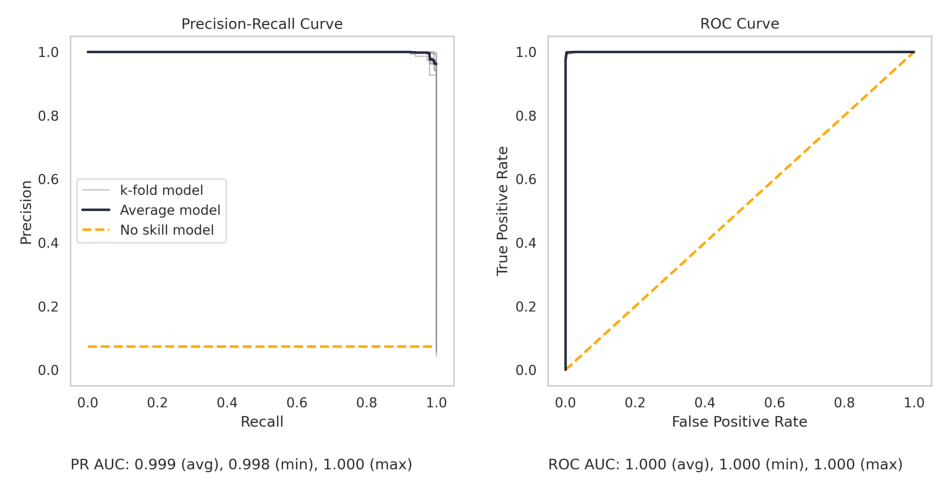

In [43]:
display_model_curves(file_list, model_type="rf")

What about the XGBoost model?

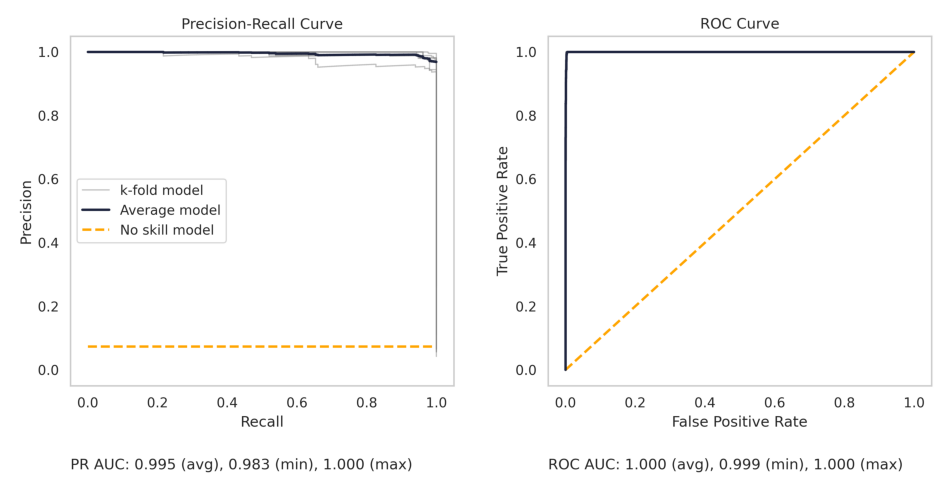

In [39]:
display_model_curves(file_list, model_type="xgb")

You can try out the other models as well. Here's the Naive Bayes model curves (it's not as good).

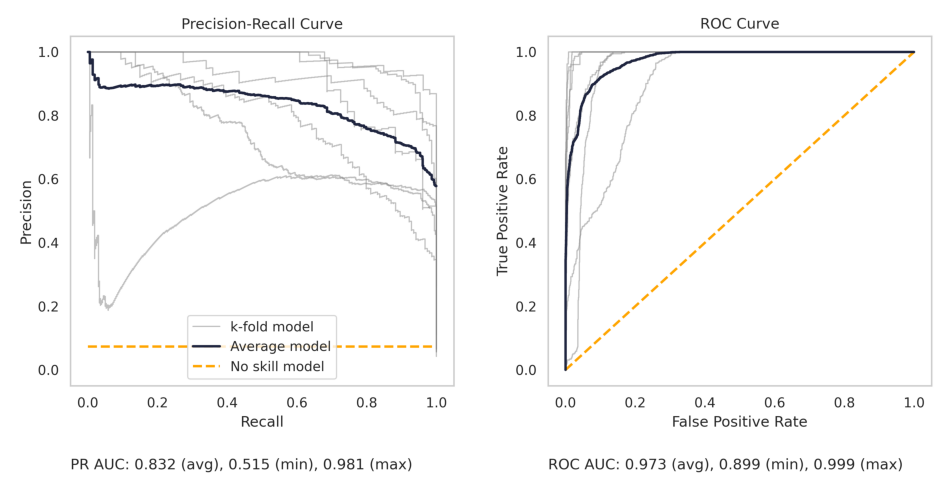

In [40]:
display_model_curves(file_list, model_type="nb")

## Lolipop Chart
The lolipop chart is a way to visualize the relative performance of each model against each other. The `plot_lollipop_results` function is in the [visualize.py](https://github.com/tvhahn/tspipe/blob/master/src/visualization/visualize.py#L280) script and it relies on the `compiled_results_filtered.csv` file.

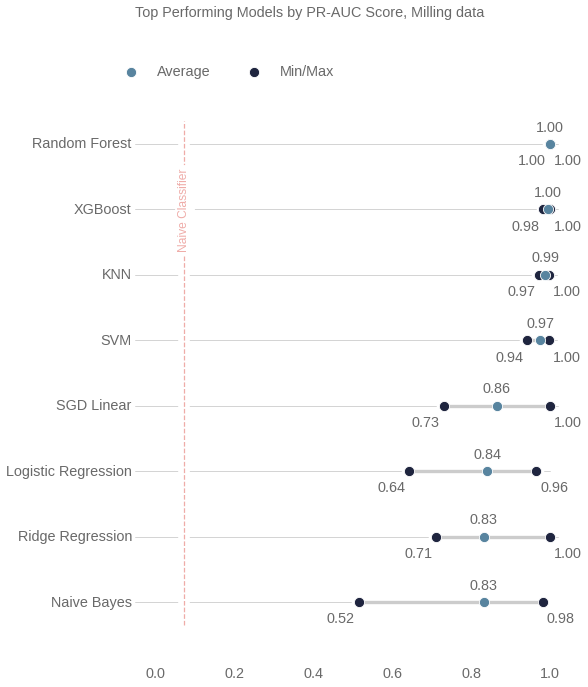

In [52]:
from src.visualization.visualize import plot_lollipop_results

path_final_results_dir = proj_dir / 'models' / 'final_results_milling_2022_08_25_final' # models from paper
df_results = pd.read_csv(path_final_results_dir / 'compiled_results_filtered.csv')


plot_lollipop_results(
    df_results,
    metric="prauc",
    percent_anom=0.0735, # calculated from feature file, in df_pc (see above)
    plt_title="Top Performing Models by PR-AUC Score, Milling data",
    save_plot=False,
    dpi=60,
)

## Feature Importance
As mentioned, the `filter.py` script can also check the feature importance for each of the models. This is done using the sklearn [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html) function. The feature importance for each k-fold, of each model, is then saved as a csv file in `final_results` folder.

Let's look at the feature importance for the random forest model.

In [5]:
from src.visualization.visualize import plot_feat_importance

path_final_results_dir = proj_dir / 'models' / 'final_results_milling_2022_08_25_final' # models from paper
df_imp = pd.read_csv(path_final_results_dir / '9569263_rf_2022-09-13-1909-12_milling_feat_imp.csv')
df_imp.head()

,metric,measure,k_fold_i,smcdc__energy_ratio_by_chunks__num_segments_10__segment_focus_6,"ae_spindle__fft_coefficient__attr_""abs""__coeff_36","vib_table__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","smcac__fft_coefficient__attr_""abs""__coeff_63","vib_table__fft_coefficient__attr_""imag""__coeff_95","smcac__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""var""","vib_spindle__fft_coefficient__attr_""imag""__coeff_63",vib_spindle__symmetry_looking__r_0.7000000000000001,"ae_spindle__fft_coefficient__attr_""abs""__coeff_49","vib_table__fft_coefficient__attr_""angle""__coeff_42"
0,accuracy,mean,0,0.008515,0.036362,0.067776,0.016241,-8.297034e-05,0.101307,0.000000,0.0,0.021033,0.000010
1,accuracy,std,0,0.001638,0.002521,0.001974,0.001480,1.375907e-04,0.003116,0.000000,0.0,0.002033,0.000056
2,f1,mean,0,0.039907,0.196004,0.385306,0.078904,-3.698481e-04,0.643756,0.000000,0.0,0.104627,0.000047
3,f1,std,0,0.008015,0.016349,0.014093,0.007768,6.133236e-04,0.020277,0.000000,0.0,0.011149,0.000252
4,average_precision,mean,0,0.000625,0.067033,0.113681,0.001952,5.921189e-17,0.525847,0.000004,0.0,0.001467,0.000005


The `plot_feat_importance` function takes the average across all k-folds for a specific metric and plots them. You can see the selected features in the dataframe above. We will add easier to read names for each of the features.

In [6]:
feat_orig_names = [
    "smcdc__energy_ratio_by_chunks__num_segments_10__segment_focus_6",
    'ae_spindle__fft_coefficient__attr_"abs"__coeff_36',
    'vib_table__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"min"',
    'smcac__fft_coefficient__attr_"abs"__coeff_63',
    'vib_table__fft_coefficient__attr_"imag"__coeff_95',
    'smcac__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"',
    'vib_spindle__fft_coefficient__attr_"imag"__coeff_63',
    "vib_spindle__symmetry_looking__r_0.7000000000000001",
    'ae_spindle__fft_coefficient__attr_"abs"__coeff_49',
    'vib_table__fft_coefficient__attr_"angle"__coeff_42',
]

feat_renamed = [
    "Energy ratio by chunks\nAC current",
    "FFT coef. 36 (abs),\nAE spindle",
    "Linear trend intercept,\nVibe table",
    "FFT coef. 63 (abs),\nAC current",
    "FFT coef. 95 (imag),\nVibe table",
    "Linear trend std. error,\nAC current",
    "FFT coef. 63 (imag),\nVibe spindle",
    "Symmetry looking,\nVibe spindle",
    "FFT coef. 49 (abs),\nAE spindle",
    "FFT coef. 42 (angle),\nVibe table",
]

# zip the original names with the renamed names into a dictionary
feature_name_map = dict(zip(feat_orig_names, feat_renamed))

And plot...

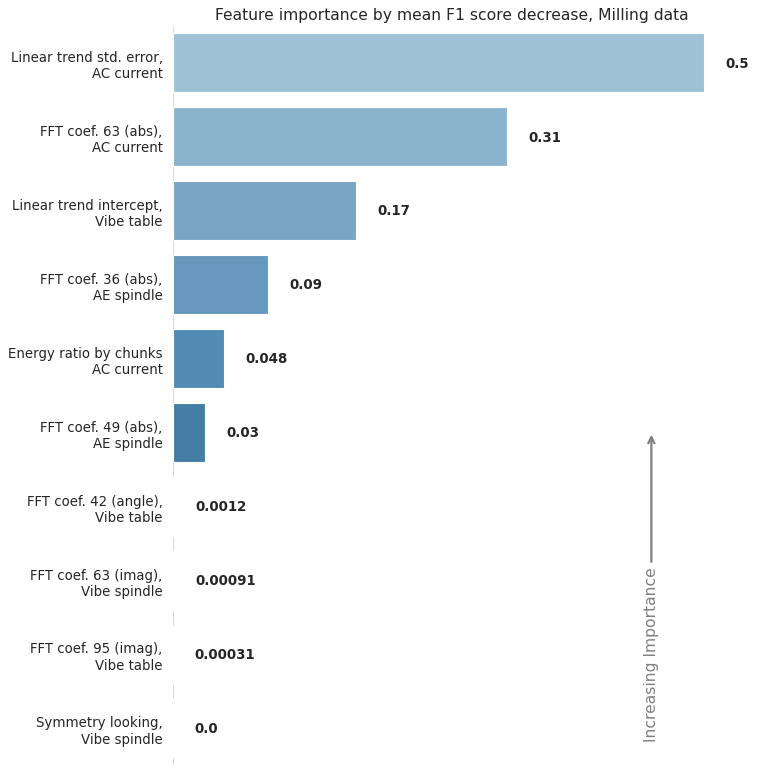

In [11]:
plot_feat_importance(
    df_imp,
    feature_name_map=feature_name_map,
    metric="f1",
    plt_title="Feature importance by mean F1 score decrease, Milling data",
    save_name="milling_feature_importance_rf",
    save_plot=False,
    dpi=80,
)